# Table of Contents

1. Data Preprocessing

2. Feature Engineering

3. Model Building

4. Model Evaluation (make prediciton on the holdout dataset as well)

5. Prediction Interpretation

6. Recommendation

---

In [61]:
# import libraries
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import missingno as msno
import warnings
# import tensorflow as tf
# from tensorflow import keras


In [56]:
from utils import you_never_know_where_it_is as ynk

# I. Data Preprocessing

In [35]:
df = pd.read_csv('./data/loan_train.csv')

Let's write a class to write all the data preprocessing steps.

In [ ]:
class DataPreprocessor:
    def __init__(self):
        pass
    

Some plot functions

In [78]:
# a helper function to examine the numerical features
def analyze_numerical(df, features):
    num_features = len(features)
    rows = num_features // 2 + num_features % 2  # Calculate rows needed
    cols = 2

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        
        # Main figure creation
        fig, axes = plt.subplots(rows, cols, figsize=(40, 60))  # Increase the figsize values
        axes = axes.flatten() 

        for i in range(len(axes)):
            if i < len(features):
                col = features[i]
                sns.histplot(data=df, x=col, kde=True, ax=axes[i])  
                axes[i].set_title(f"Distribution of {col}")
            else:
                fig.delaxes(axes[i])
            
        plt.tight_layout() 
        plt.show()

## I.1 Basic Overview Analysis

Eyeball data, check missing values, duplicates

In [36]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29777 entries, 0 to 29776
Data columns (total 52 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          29774 non-null  float64
 1   member_id                   29774 non-null  float64
 2   loan_amnt                   29774 non-null  float64
 3   funded_amnt                 29774 non-null  float64
 4   funded_amnt_inv             29774 non-null  float64
 5   term                        29774 non-null  object 
 6   int_rate                    29774 non-null  object 
 7   installment                 29774 non-null  float64
 8   grade                       29774 non-null  object 
 9   sub_grade                   29774 non-null  object 
 10  emp_title                   27955 non-null  object 
 11  emp_length                  29015 non-null  object 
 12  home_ownership              29774 non-null  object 
 13  annual_inc                  297

`Check duplicates`

In [37]:
# check duplicates
df.duplicated().sum()

# remove duplicates 
df = df.drop_duplicates()


`Check missing values`

In [ ]:
# missing values as a percentage
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values = missing_values / len(df) * 100
missing_values = missing_values.sort_values(ascending=False)

In [39]:
# number of missing cols containing missing values
print('number of cols containing missing values:', len(missing_values))

# number of missing values in the loan_status 
print('number of missing values in the loan_status:', df['loan_status'].isnull().sum())

number of cols containing missing values: 51
number of missing values in the loan_status: 0


Apparently, all cols contain missing values except the label. This is quite annoying

Here is the plan to deal with missing values:
- if the missing values are less than 1% of the total, we can drop the rows 

- if the missing values are less than 10% of the total we can do some further investigation to see if it's appropriate to fill these missing values with median or mode 

- If the missing values are greater than 10%, let's investigation to see if there is a reason for the missing values. If not, we can decide to drop some cols wikth extremely high missing values

In [ ]:
# get the index for those have value less than 1% in missing_values
small_missing_values= missing_values[missing_values < 1].index

small_missing_values.tolist()

# drop the rows with missing values in the small_missing_values
df = df.dropna(subset=small_missing_values)

In [50]:
# check the remaining missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values = missing_values / len(df) * 100
missing_values = missing_values.sort_values(ascending=False)
missing_values

next_pymnt_d              92.307172
mths_since_last_record    91.593369
mths_since_last_delinq    63.606225
desc                      31.725304
emp_title                  6.062246
pub_rec_bankruptcies       2.919486
emp_length                 2.547361
dtype: float64

These faetures are a bit complicated, and require careful handling. Thus, we will take care of them in **feature engineering** 

## I.2 Univariate Analysis

### I.2.1 Numerical Features

Visualize histogram of all these numerical features to see the distribution of the data and check for outliers as well as invalid numerical features. Some of them could be potential categorical features instead

In [57]:
# extract numerical features from the dataset 
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()

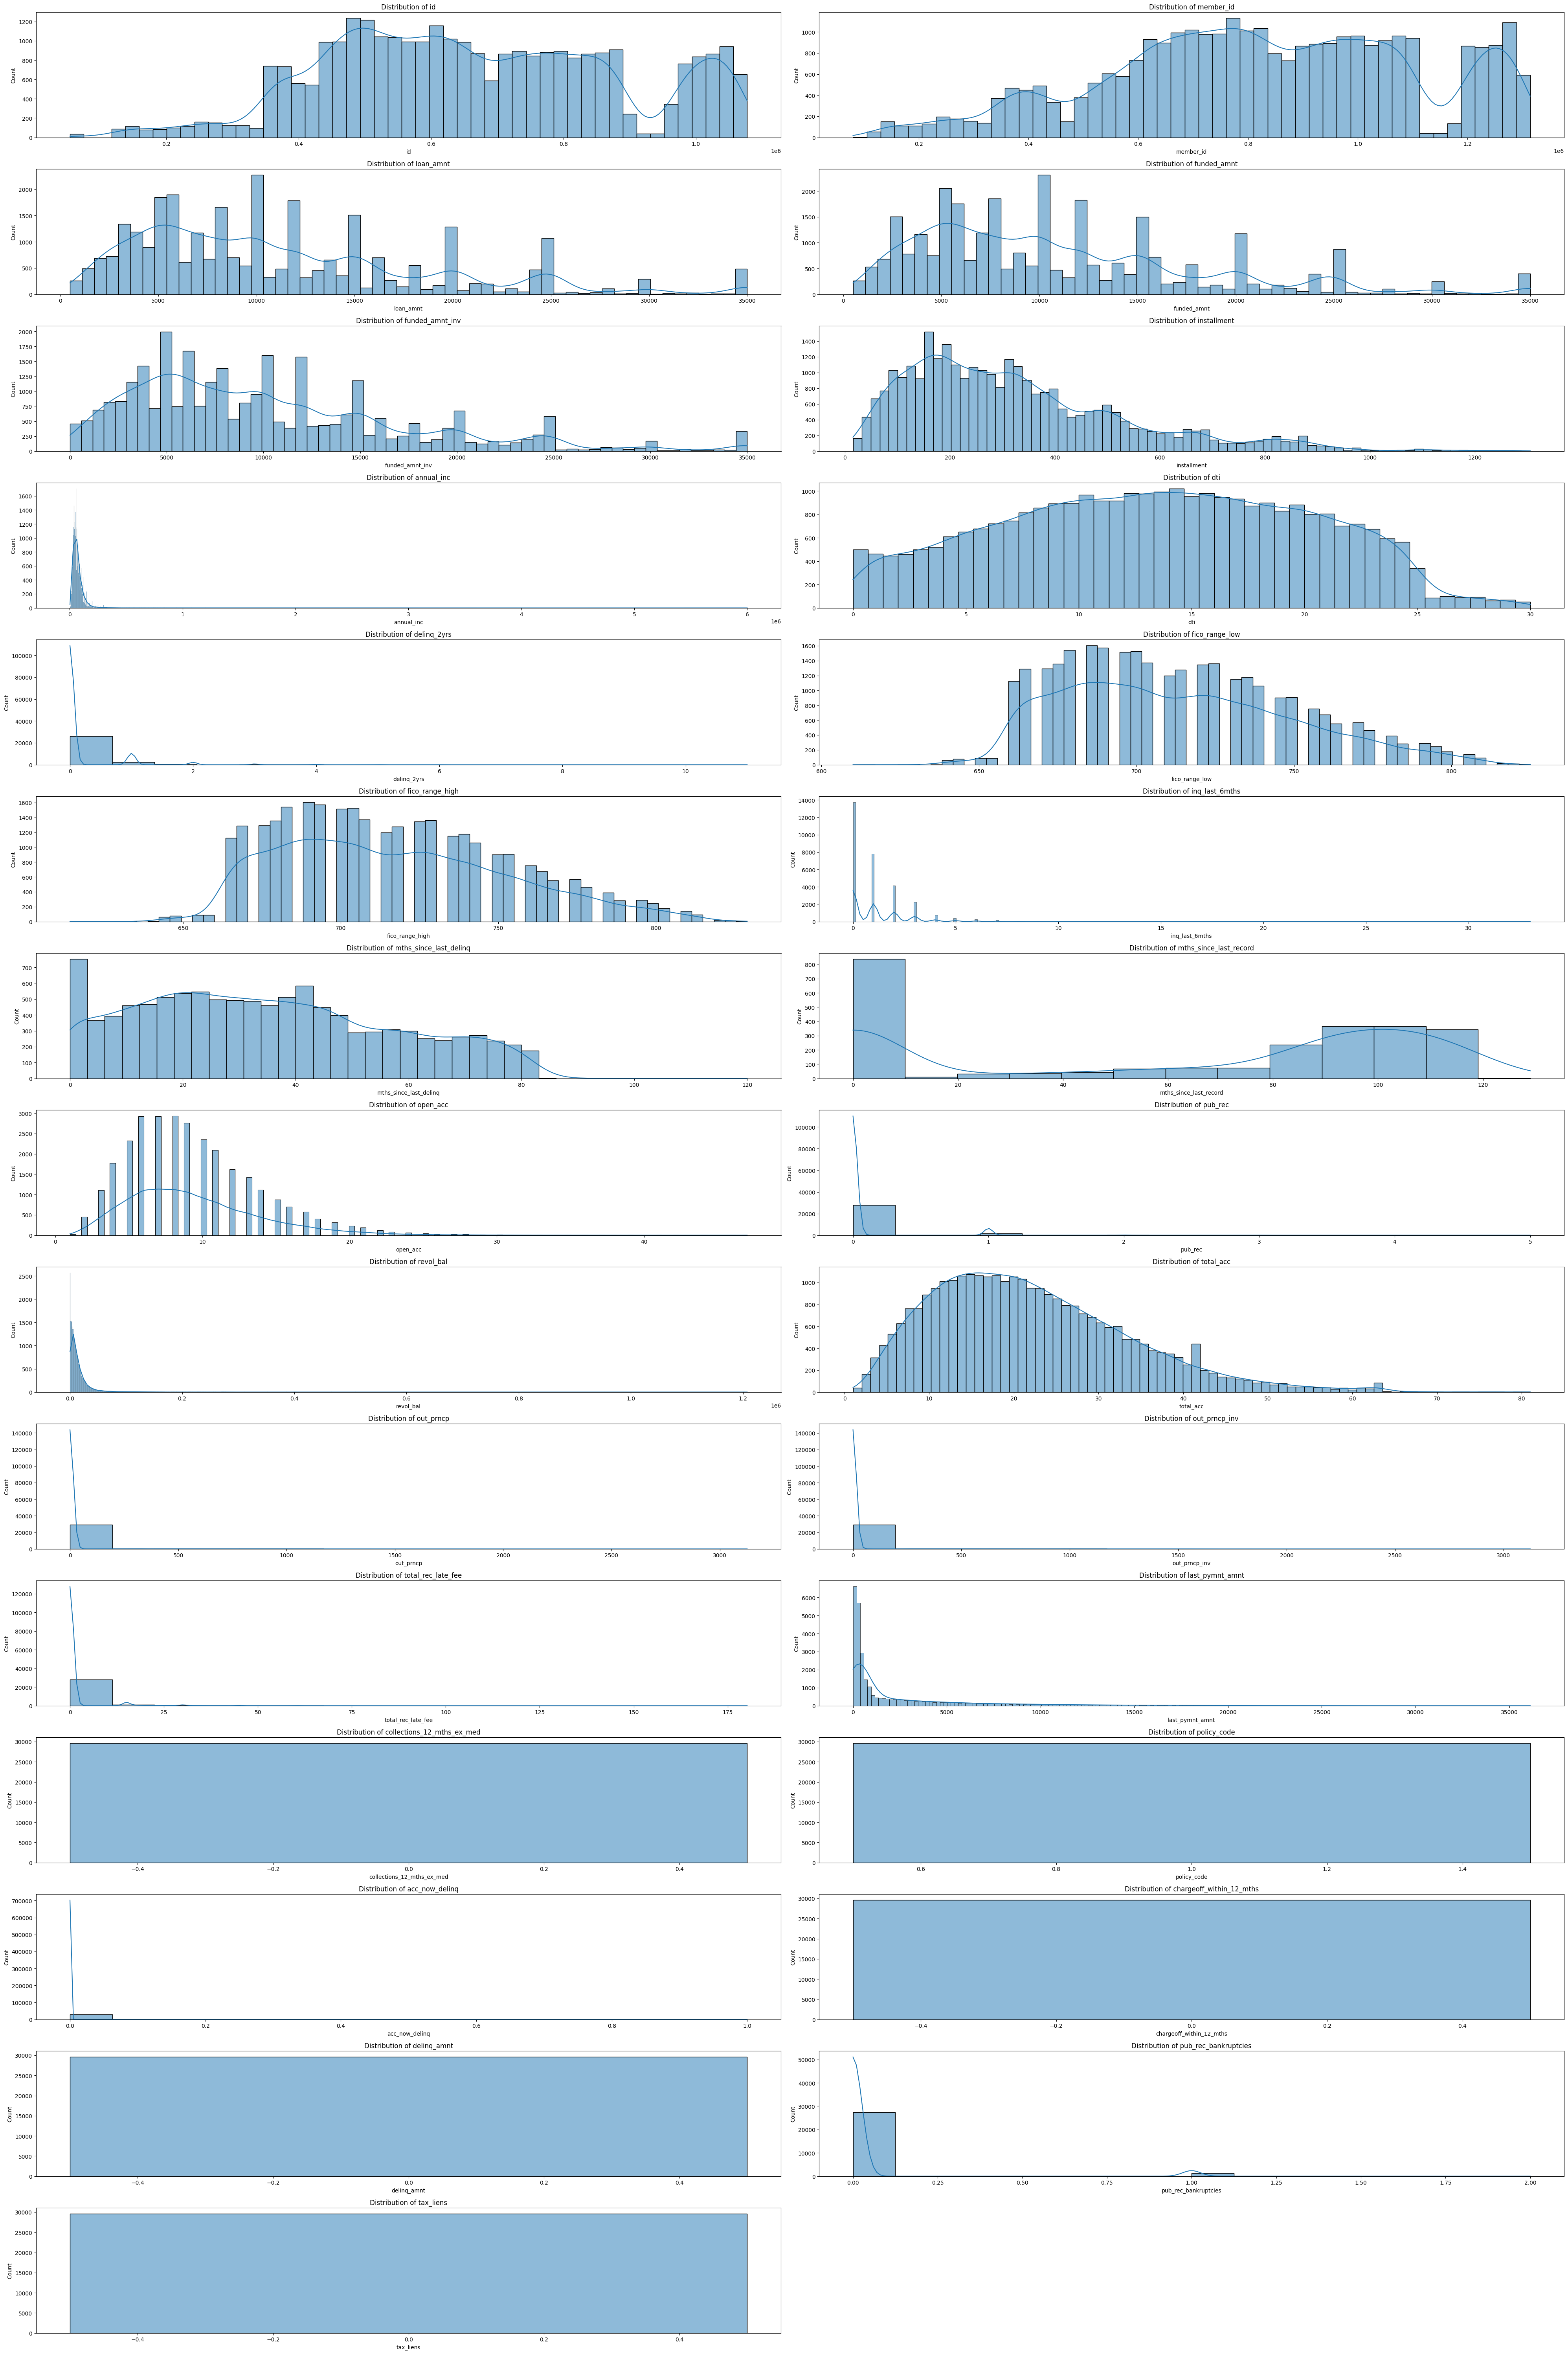

In [79]:
analyze_numerical(df, numerical_features)